In [129]:
# imports
import bz2
import pickle5 as pickle
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [130]:
# functions
# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [131]:


df = decompress_pickle('6nutrients.pbz2')



In [132]:
def score_diff(id, shiftid, diff, shiftdiff):
    if id!=shiftid or shiftid==pd.isnull:
        return -1
    elif diff>=0 and shiftdiff>=0:
        return 1
    else:
        return 0

df1 = df.copy()

# drop the columns we don't need
df1.drop(columns=['total.carbs','total.fat','total.protein','total.sodium','total.sugar', 'goal.carbs','goal.fat','goal.protein','goal.sodium','goal.sugar'],inplace=True)


days = 2

for day in range(1,days):

    # if day > 2:
    #     # we can drop old columns to save some space
    #     df1 = df1.drop(columns=['difference'+str(day-2),'shiftid'+str(day-1),'shiftdiff'+str(day-1)])

    if day > 1:
        # shift the difference
        df1.insert(1, 'difference'+str(day-1), df1.shift(periods=-day, axis=0)['difference0'])
    else:
        df1['difference'+str(day-1)] = df.apply(lambda x: x['total.calories'] - x['goal.calories'], axis=1)

    # remove rows with only x day worth of data
    df1 = df1.groupby('id').filter(lambda x : len(x)>7)



    # add shiftid column
    df1.insert(1, 'shiftid'+str(day), df1.shift(periods=-day, axis=0)['id'])

    df1['shiftdiff'+str(day)] =  df1.shift(periods=-day, axis=0)['difference'+str(day-1)]
    df1['new_success'+str(day)] = df1.apply(lambda x: score_diff(x['id'],\
        x['shiftid'+str(day)],x['difference'+str(day-1)],x['shiftdiff'+str(day)]), axis=1)

    print("Day: "+str(day))
    df1['new_success'+str(day)].value_counts()

Day: 1


 0    457371
 1     49691
-1      7272
Name: new_success1, dtype: int64

In [133]:
# add up the ability to hit their goal 0/1 with a count of how often that id appears
df2 = df1.groupby(['id'])['new_success1'].sum()
df3 = df1.groupby(['id'])['id'].count().to_frame()
df4 = pd.concat([df2,df3],axis=1)
df4.info()
df4.rename( columns={'id':'total_count', 'new_success1':'total_success'}, inplace=True )
df4['success_prob'] = df4.apply(lambda x: x['total_success'] / x['total_count'], axis=1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7272 entries, 1 to 9897
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   new_success1  7272 non-null   int64
 1   id            7272 non-null   int64
dtypes: int64(2)
memory usage: 170.4 KB


/home/arthurfmay/anaconda3/envs/nutrition-analysis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


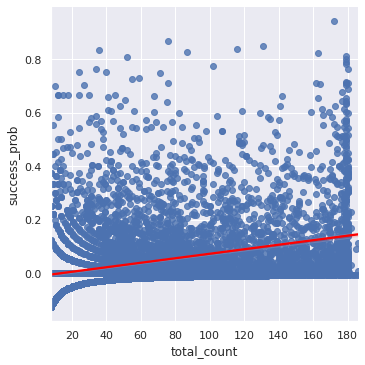

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.lmplot('total_count', 'success_prob', data=df4, line_kws={'color': 'red'})
plot.savefig("lmplot.png")

In [135]:
# predict what their calorie count would be for the next day and if it likely the will hit their goal.
